# Algoritmo de red convolucional para la clasificación detección temprana de supernovas

In [2]:
import numpy as np
import pickle as pkl
import os
import sys
import time
import torch
from torch import nn
import torch.nn.functional as F
import torchvision
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

## Red convolucional

### Se abre la data pre-procesada

In [3]:
# Función para cargar el contenido del archivo .pkl
def load_pickle_data(filename):
    with open(filename, 'rb') as f:
        data = pkl.load(f)
    return data

# Cargar el archivo
filename = 'processed_data.pkl' 
data_procesada = load_pickle_data(filename)

# Visualizar el contenido
print('keys de pkl', data_procesada.keys())
print('keys de Test',data_procesada['Validation'].keys())
data_procesada['Validation']['labels']

keys de pkl dict_keys(['Train', 'Validation', 'Test'])
keys de Test dict_keys(['images', 'labels', 'features'])


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3,

### Se generan las variables para Train, Val y Test

In [4]:
def preparar_imagenes_para_modelo(data_dict, key_principal='Train', key_imagenes='images'):
    # Extraer imágenes del diccionario
    imagenes = data_dict[key_principal][key_imagenes]
    
    # Cambiar el orden de las dimensiones a [canales, altura, ancho]
    imagenes = np.transpose(imagenes, (0, 3, 1, 2))
    
    # Convertir a tensor de PyTorch
    imagenes_tensor = torch.tensor(imagenes, dtype=torch.float32)

    
    return imagenes_tensor

# Preparar las imágenes para el modelo
Train = preparar_imagenes_para_modelo(data_procesada)
Val = preparar_imagenes_para_modelo(data_procesada, key_principal='Validation')
Test = preparar_imagenes_para_modelo(data_procesada, key_principal='Test')

print('tipo de dato de Train:', Train.type)
print('forma de Train:', Train.shape)
print('forma de Validation:', Val.shape)
print('forma de Test:', Test.shape)



tipo de dato de Train: <built-in method type of Tensor object at 0x000001D65C3012B0>
forma de Train: torch.Size([72710, 3, 21, 21])
forma de Validation: torch.Size([500, 3, 21, 21])
forma de Test: torch.Size([500, 3, 21, 21])


### Función que extrae las etiquetas, es una mouskierramienta que nos servirá más adelante

In [5]:
def extraer_etiquetas(data_dict, key_principal='Train', key_etiquetas='labels'):
    # Extraer etiquetas del diccionario
    etiquetas = data_dict[key_principal][key_etiquetas]
    # Convertir a tensor de PyTorch
    etiquetas_tensor = torch.tensor(etiquetas, dtype=torch.long)  # Usamos dtype long porque son índices de clase
    return etiquetas_tensor


### Extracción de metadata:

In [6]:
def extraer_metadata(data_dict, key_principal='Train', key_metadata='features'):
    # Extraer características de metadatos del diccionario
    metadata = data_dict[key_principal][key_metadata]
    
    # Convertir explícitamente a float32
    metadata = metadata.astype(np.float32)
    
    # Convertir a tensor de PyTorch
    metadata_tensor = torch.tensor(metadata, dtype=torch.float32)
    
    return metadata_tensor


# Extraer características de metadatos para los conjuntos de datos
metadata_train = extraer_metadata(data_procesada)
metadata_val = extraer_metadata(data_procesada, key_principal='Validation')
metadata_test = extraer_metadata(data_procesada, key_principal='Test')

print('forma de metadata_train:', metadata_train.shape)
print('forma de metadata_val:', metadata_val.shape)
print('forma de metadata_test:', metadata_test.shape)

metadata_val


forma de metadata_train: torch.Size([72710, 26])
forma de metadata_val: torch.Size([500, 26])
forma de metadata_test: torch.Size([500, 26])


tensor([[ 7.7878e-01, -6.2952e-01,  8.8655e-02,  ..., -1.4237e-01,
         -2.2997e-01, -1.3517e-01],
        [ 7.6781e-01, -6.2212e-01,  1.2532e+00,  ..., -2.5771e-01,
         -3.8337e-01,  9.2198e-02],
        [ 7.5052e-01, -6.1387e-01, -1.0466e+00,  ..., -3.4228e-01,
         -3.9726e-01,  3.2286e-03],
        ...,
        [-1.8353e+00,  2.9948e+00,  8.8655e-02,  ...,  1.6006e-01,
         -2.2666e-01, -5.8001e-01],
        [-1.8213e+00,  1.4213e+00,  8.8655e-02,  ...,  5.7526e-01,
         -3.6618e-01,  6.2541e-02],
        [ 7.7110e-01,  1.4931e+00,  1.2525e+00,  ...,  3.3484e+00,
         -1.3608e-01, -4.7127e-01]])

## Modelo convolucional, incorporando invariancia rotacional

## Aumento de capa Fully connected

In [7]:
class CNNModel(nn.Module):
    def __init__(self, dropout_p):
        super(CNNModel, self).__init__()
        self.padding = nn.ZeroPad2d(4)
        self.dropout_p = dropout_p
        self.conv_blocks = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=5, stride=1, padding=0),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            # nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),  # Tamaño del kernel ajustado a 5, padding ajustado
            # nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(64)
        )
        self.mlp1 = nn.Sequential(
            nn.Flatten(),
            nn.Linear(2304, 128),
            nn.ReLU(),
            nn.Dropout(p=self.dropout_p),
            nn.Linear(128, 64),
            nn.ReLU(),
        )
        self.metadata_bn = nn.BatchNorm1d(26)
        self.mlp2 = nn.Sequential(
            nn.Linear(90, 64),
            nn.ReLU(),
        )
        self.mlp3 = nn.Sequential(
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 5),
        )


    def rotate_input(self, x):
        # Rotaciones para la invariancia 
        x_90 = torch.rot90(x, 1, [2, 3])
        x_180 = torch.rot90(x, 2, [2, 3])
        x_270 = torch.rot90(x, 3, [2, 3])
        return torch.cat([x, x_90, x_180, x_270], dim=0)
    
    def cyclic_pooling(self, x):
        B = x.size(0) // 4
        return (x[:B] + x[B:2*B] + x[2*B:3*B] + x[3*B:]) / 4.0

    def forward(self, x, metadata):
        # Verificación de dimensiones de metadatos
        if metadata.dim() != 2:
            raise ValueError("La metadata debe ser un tensor de 2 dimensiones")

        # Zero padding
        x = self.padding(x)

        # Rotación de la entrada y bloques de convolución
        x_rotated = self.rotate_input(x)
        x_rotated = self.conv_blocks(x_rotated)

        # Primera capa fully connected
        x_rotated_dense = self.mlp1(x_rotated)

        # Pooling Cíclico
        x_pooled = self.cyclic_pooling(x_rotated_dense)

        # Normalización de metadatos
        normalized_metadata = self.metadata_bn(metadata)

        # Concatenación de características de imagen y metadatos
        combined_features = torch.cat([x_pooled, normalized_metadata], dim=1)

        # Pasar por la segunda parte del MLP
        out = self.mlp2(combined_features)
        out = self.mlp3(out)

        return out


## Función de entrenamiento y visualización

In [8]:
def show_curves(curves):
    fig, ax = plt.subplots(1, 2, figsize=(13, 5))
    fig.set_facecolor('white')

    epochs = np.arange(len(curves["val_loss"])) + 1

    ax[0].plot(epochs, curves['val_loss'], label='validation')
    ax[0].plot(epochs, curves['train_loss'], label='training')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].set_title('Loss evolution during training')
    ax[0].legend()

    ax[1].plot(epochs, curves['val_acc'], label='validation')
    ax[1].plot(epochs, curves['train_acc'], label='training')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_title('Accuracy evolution during training')
    ax[1].legend()

    plt.show()

In [9]:
def perdida_regularizada_entropia(salidas, objetivos, beta=0.1):
    # Pérdida de entropía cruzada
    perdida_ec = F.cross_entropy(salidas, objetivos, reduction='mean')
    
    # Calcula la entropía de las probabilidades
    probabilidades = F.softmax(salidas, dim=1)
    entropia = -torch.sum(probabilidades * torch.log(probabilidades + 1e-9), dim=1)
    entropia_reg = torch.mean(entropia)
    
    # Pérdida combinada
    perdida_total = perdida_ec - beta * entropia_reg
    
    return perdida_total


In [10]:
def train_step(x_batch, y_batch, metadata_batch, model, optimizer, criterion, beta):
    # Predicción
    y_predicted = model(x_batch, metadata_batch)

    # Cálculo de la pérdida
    loss = criterion(y_predicted, y_batch, beta=beta)

    # Actualización de parámetros
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return y_predicted, loss




def evaluate(data_loader, model, criterion, use_gpu):
    cumulative_loss = 0
    cumulative_predictions = 0
    data_count = 0

    for x_val, y_val, metadata_val in data_loader:
        if use_gpu:
            x_val = x_val.cuda()
            y_val = y_val.cuda()
            metadata_val = metadata_val.cuda()

        y_predicted = model(x_val, metadata_val)
        
        loss = criterion(y_predicted, y_val)

        class_prediction = torch.argmax(y_predicted, axis=1).long()

        cumulative_predictions += (y_val == class_prediction).sum().item()
        cumulative_loss += loss.item()
        data_count += y_val.shape[0]

    val_acc = cumulative_predictions / data_count
    val_loss = cumulative_loss / len(data_loader)

    return val_acc, val_loss



def train_model(
    model,
    train_data_images,
    train_data_labels,
    train_data_metadata,
    val_data_images,
    val_data_labels,
    val_data_metadata,
    epochs,
    criterion,
    batch_size,
    lr,
    use_gpu,
    beta=0.1,
    patience=12,
    val_batch_size=None
):
    if use_gpu:
        model.cuda()

    # Definición de dataloader
    train_dataset = torch.utils.data.TensorDataset(train_data_images, train_data_labels, train_data_metadata)
    val_dataset = torch.utils.data.TensorDataset(val_data_images, val_data_labels, val_data_metadata)

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=use_gpu)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=val_batch_size or len(val_data_images), shuffle=False, pin_memory=use_gpu)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    curves = {
        "train_acc": [],
        "val_acc": [],
        "train_loss": [],
        "val_loss": [],
    }

    t0 = time.perf_counter()
    best_val_loss = float('inf')
    epochs_without_improvement = 0

    for epoch in range(epochs):
        print(f"\rEpoch {epoch + 1}/{epochs}")
        cumulative_train_loss = 0
        cumulative_train_corrects = 0
        train_loss_count = 0
        train_acc_count = 0

        # Entrenamiento del modelo
        model.train()

        for i, (x_batch, y_batch, metadata_batch) in enumerate(train_loader):
            if use_gpu:
                x_batch = x_batch.cuda()
                y_batch = y_batch.cuda()
                metadata_batch = metadata_batch.cuda()

            y_predicted, loss = train_step(x_batch, y_batch, metadata_batch, model, optimizer, criterion, beta)



            cumulative_train_loss += loss.item()
            train_loss_count += 1
            train_acc_count += y_batch.shape[0]

            # Calculamos número de aciertos
            class_prediction = torch.argmax(y_predicted, axis=1).long()
            cumulative_train_corrects += (y_batch == class_prediction).sum().item()

            if (i + 1) % 117 == 0:
                print(f"Iteration {i + 1} - Batch {i + 1}/{len(train_loader)} - Train loss: {cumulative_train_loss / train_loss_count}, Train acc: {cumulative_train_corrects / train_acc_count}")

        model.eval()
        with torch.no_grad():
            val_acc, val_loss = evaluate(val_loader, model, criterion, use_gpu)

        print(f"Val loss: {val_loss}, Val acc: {val_acc}")

        train_loss = cumulative_train_loss / train_loss_count
        train_acc = cumulative_train_corrects / train_acc_count

        curves["train_acc"].append(train_acc)
        curves["val_acc"].append(val_acc)
        curves["train_loss"].append(train_loss)
        curves["val_loss"].append(val_loss)

        # Lógica de early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1

        if epochs_without_improvement == patience:
            print(f"Early stopping at epoch {epoch + 1} due to no improvement after {patience} epochs.")
            break

    print(f"Tiempo total de entrenamiento: {time.perf_counter() - t0:.4f} [s]")
    model.cpu()

    return curves


### Búsqueda de hiperparámetros con funciones de sklearn

In [11]:
# Dividir las imágenes y metadatos en conjuntos de entrenamiento y validación
Train_images = preparar_imagenes_para_modelo(data_procesada)
Val_images = preparar_imagenes_para_modelo(data_procesada, key_principal='Validation')
Train_labels = extraer_etiquetas(data_procesada)
Val_labels = extraer_etiquetas(data_procesada, key_principal='Validation')
# Extraer características de metadatos para los conjuntos de datos
metadata_train = extraer_metadata(data_procesada)
metadata_val = extraer_metadata(data_procesada, key_principal='Validation')
metadata_test = extraer_metadata(data_procesada, key_principal='Test')


#### Mejores parámetros encontrados:  {'lr': 5e-05, 'epochs': 50, 'dropout_p': 0.6, 'batch_size': 16}

## Instanciamos el modelo

### Primera combinación de hiperparámetros

Epoch 1/100
Iteration 117 - Batch 117/1137 - Train loss: 0.768439329842217, Train acc: 0.6792200854700855
Iteration 234 - Batch 234/1137 - Train loss: 0.5815888703124136, Train acc: 0.7640224358974359
Iteration 351 - Batch 351/1137 - Train loss: 0.4995910381829297, Train acc: 0.7991898148148148
Iteration 468 - Batch 468/1137 - Train loss: 0.45060108586126923, Train acc: 0.8203125
Iteration 585 - Batch 585/1137 - Train loss: 0.41723969739217026, Train acc: 0.8340544871794872
Iteration 702 - Batch 702/1137 - Train loss: 0.3917016897700791, Train acc: 0.8447738603988604
Iteration 819 - Batch 819/1137 - Train loss: 0.37607711838314967, Train acc: 0.8514003357753358
Iteration 936 - Batch 936/1137 - Train loss: 0.3597040059777279, Train acc: 0.8583233173076923
Iteration 1053 - Batch 1053/1137 - Train loss: 0.3482750190841167, Train acc: 0.862965930674264
Val loss: 0.24322497844696045, Val acc: 0.896
Epoch 2/100
Iteration 117 - Batch 117/1137 - Train loss: 0.25014359809649295, Train acc: 0.90

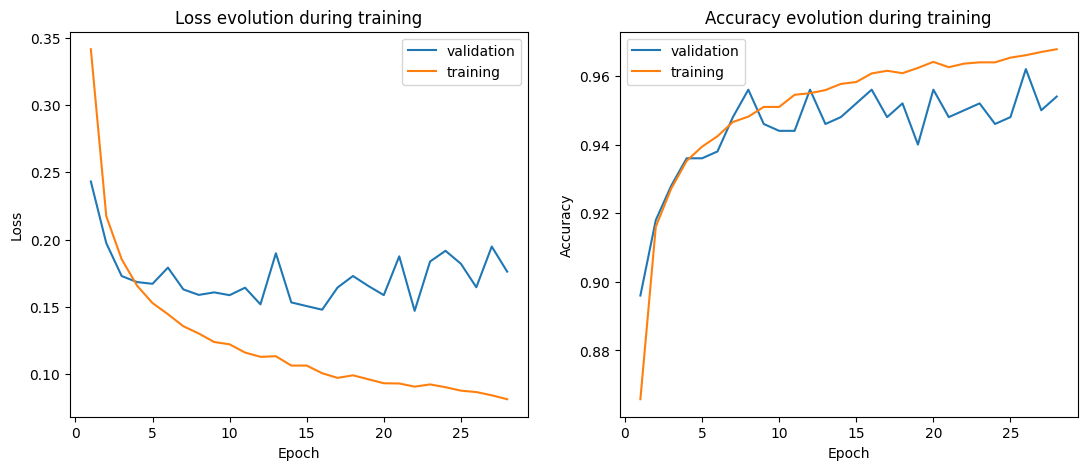

In [12]:
#{'dropout_p': 0.8, 'batch_size': 64, 'lr': 0.001, 'beta': 0.1}# Instanciación del modelo
lr = 1e-3
dropout_p = 0.8
batch_size = 64
criterion = perdida_regularizada_entropia
epochs = 100
model = CNNModel(dropout_p=dropout_p)

curves = train_model(
    model,
    Train_images,
    Train_labels,
    metadata_train,
    Val_images,
    Val_labels,
    metadata_val,
    epochs,
    criterion,
    batch_size,
    lr,
    use_gpu=True,
    beta=0.1,
    patience=6
)

# Mostrar las curvas de entrenamiento
show_curves(curves)

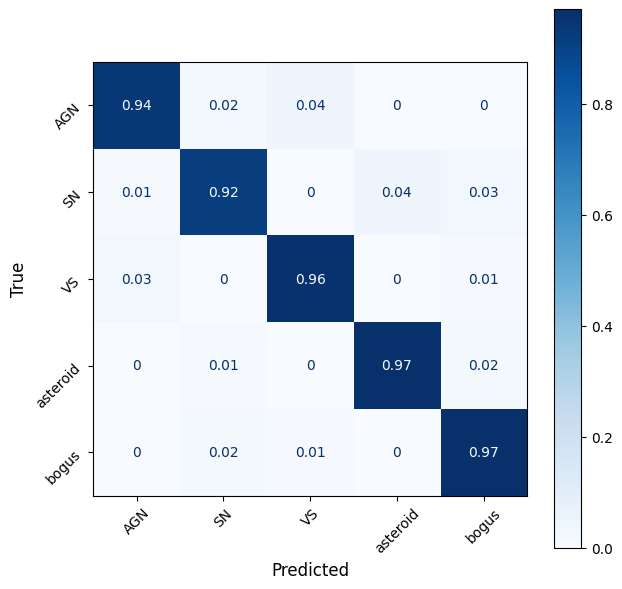

              precision    recall  f1-score   support

         AGN       0.96      0.94      0.95       100
          SN       0.95      0.92      0.93       100
          VS       0.95      0.96      0.96       100
    asteroid       0.96      0.97      0.97       100
       bogus       0.94      0.97      0.96       100

    accuracy                           0.95       500
   macro avg       0.95      0.95      0.95       500
weighted avg       0.95      0.95      0.95       500



In [17]:
def predict(model, data_loader, use_gpu):
    all_preds = []
    all_true = []
    
    if use_gpu:
        model = model.cuda()  # Transfiere el modelo a la GPU
    
    model.eval()
    with torch.no_grad():
        for inputs, labels, metadata in data_loader:
            if use_gpu:
                inputs = inputs.cuda()
                metadata = metadata.cuda()

            outputs = model(inputs, metadata)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_true.extend(labels.numpy())

    return all_true, all_preds

# Asegúrate de tener tus datos de test preparados
Test_images = preparar_imagenes_para_modelo(data_procesada, key_principal='Test')
Test_labels = extraer_etiquetas(data_procesada, key_principal='Test')
metadata_test = extraer_metadata(data_procesada, key_principal='Test')

# Definición de dataloader
test_dataset = torch.utils.data.TensorDataset(Test_images, Test_labels, metadata_test)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

true_labels, predicted_labels = predict(model, test_loader, use_gpu=True)
cm = confusion_matrix(true_labels, predicted_labels)

# Calcula la matriz de confusión normalizada
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Visualizar la matriz de confusión normalizada
disp_normalized = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=['AGN', 'SN', 'VS', 'asteroid', 'bogus'])
fig, ax = plt.subplots(figsize=(7, 7))
disp_normalized.plot(cmap=plt.cm.Blues, ax=ax, colorbar=True)  # Muestra la barra de color para los valores normalizados

# Ajustes adicionales para mejorar la visualización
ax.set_xlabel('Predicted', fontsize=12)
ax.set_ylabel('True', fontsize=12)
ax.grid(False)

plt.xticks(rotation=45)
plt.yticks(rotation=45)

plt.show()

report = classification_report(true_labels, predicted_labels, target_names=['AGN', 'SN', 'VS', 'asteroid', 'bogus'])
print(report)


### Segunda combinación de hiperparámetros

Epoch 1/100
Iteration 117 - Batch 117/2273 - Train loss: 2.8711187391199617, Train acc: 0.10737179487179487
Iteration 234 - Batch 234/2273 - Train loss: 2.806493556397593, Train acc: 0.15397970085470086
Iteration 351 - Batch 351/2273 - Train loss: 2.787891534658579, Train acc: 0.166488603988604
Iteration 468 - Batch 468/2273 - Train loss: 2.77772869513585, Train acc: 0.17394497863247863
Iteration 585 - Batch 585/2273 - Train loss: 2.768204245608077, Train acc: 0.18178418803418803
Iteration 702 - Batch 702/2273 - Train loss: 2.7643122819074537, Train acc: 0.18425035612535612
Iteration 819 - Batch 819/2273 - Train loss: 2.7602916337340453, Train acc: 0.1874618437118437
Iteration 936 - Batch 936/2273 - Train loss: 2.7556697288130083, Train acc: 0.19270833333333334
Iteration 1053 - Batch 1053/2273 - Train loss: 2.75143807996259, Train acc: 0.19738247863247863
Iteration 1170 - Batch 1170/2273 - Train loss: 2.7470616151125005, Train acc: 0.20264423076923077
Iteration 1287 - Batch 1287/2273 -

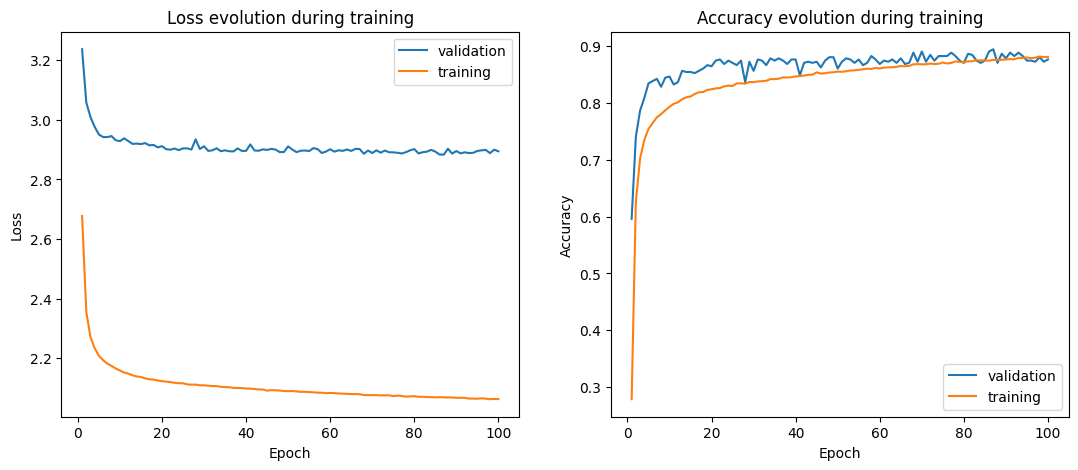

In [39]:
# Instanciación del modelo
lr = 5e-5
dropout_p = 0.7
batch_size = 32
criterion = perdida_regularizada_entropia
epochs = 100
model = CNNModel(dropout_p=dropout_p)

curves = train_model(
    model,
    Train_images,  
    Train_labels,
    metadata_train,
    Val_images,    
    Val_labels,
    metadata_val,
    epochs,
    criterion,
    batch_size,
    lr,
    use_gpu=True,
    beta=0.3,
    patience=20
)



# Mostrar las curvas de entrenamiento
show_curves(curves)



              precision    recall  f1-score   support

         AGN       0.85      0.90      0.87       100
          SN       0.82      0.74      0.78       100
          VS       0.95      0.87      0.91       100
    asteroid       0.84      0.95      0.89       100
       bogus       0.93      0.92      0.92       100

    accuracy                           0.88       500
   macro avg       0.88      0.88      0.88       500
weighted avg       0.88      0.88      0.88       500



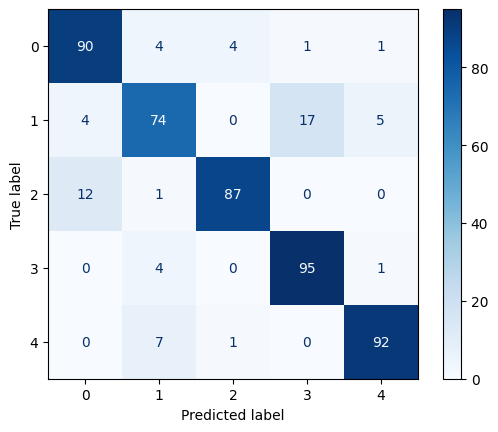

In [40]:
# Asegúrate de tener tus datos de test preparados
Test_images = preparar_imagenes_para_modelo(data_procesada, key_principal='Test')
Test_labels = extraer_etiquetas(data_procesada, key_principal='Test')
metadata_test = extraer_metadata(data_procesada, key_principal='Test')

# Definición de dataloader
test_dataset = torch.utils.data.TensorDataset(Test_images, Test_labels, metadata_test)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

true_labels, predicted_labels = predict(model, test_loader, use_gpu=True)
cm = confusion_matrix(true_labels, predicted_labels)

# Visualizar la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1, 2, 3, 4])
disp.plot(cmap=plt.cm.Blues)

report = classification_report(true_labels, predicted_labels, target_names=['AGN', 'SN', 'VS', 'asteroid', 'bogus'])

print(report)

### Tercera combinación de hiperparámtros

Epoch 1/100
Iteration 117 - Batch 117/2273 - Train loss: 3.2907093182588234, Train acc: 0.140758547008547
Iteration 234 - Batch 234/2273 - Train loss: 3.223802490112109, Train acc: 0.1685363247863248
Iteration 351 - Batch 351/2273 - Train loss: 3.199030294717207, Train acc: 0.18037749287749288
Iteration 468 - Batch 468/2273 - Train loss: 3.18558989223252, Train acc: 0.18856837606837606
Iteration 585 - Batch 585/2273 - Train loss: 3.1773830303779014, Train acc: 0.1934294871794872
Iteration 702 - Batch 702/2273 - Train loss: 3.1709815722245436, Train acc: 0.1985844017094017
Iteration 819 - Batch 819/2273 - Train loss: 3.162469085756239, Train acc: 0.207226800976801
Iteration 936 - Batch 936/2273 - Train loss: 3.154498031251451, Train acc: 0.21661324786324787
Iteration 1053 - Batch 1053/2273 - Train loss: 3.1440743249818923, Train acc: 0.2289292497625831
Iteration 1170 - Batch 1170/2273 - Train loss: 3.130695722041986, Train acc: 0.24289529914529914
Iteration 1287 - Batch 1287/2273 - Trai

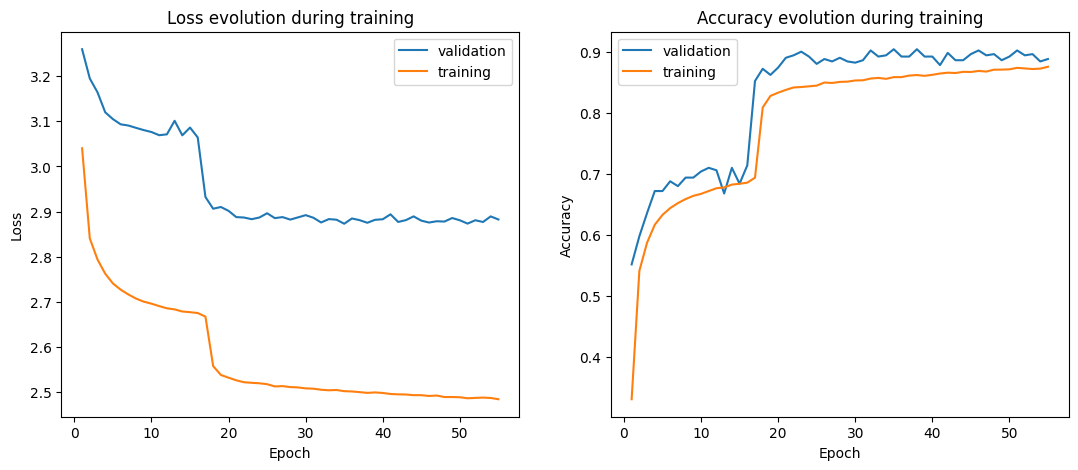

In [41]:
# Instanciación del modelo
lr = 5e-5
dropout_p = 0.6
batch_size = 32
criterion = perdida_regularizada_entropia
epochs = 100
model = CNNModel(dropout_p=dropout_p)

curves = train_model(
    model,
    Train_images,  
    Train_labels,
    metadata_train,
    Val_images,    
    Val_labels,
    metadata_val,
    epochs,
    criterion,
    batch_size,
    lr,
    use_gpu=True,
    beta=0.2,
    patience=20
)



# Mostrar las curvas de entrenamiento
show_curves(curves)



              precision    recall  f1-score   support

         AGN       0.91      0.86      0.88       100
          SN       0.89      0.78      0.83       100
          VS       0.92      0.93      0.93       100
    asteroid       0.86      0.95      0.90       100
       bogus       0.90      0.94      0.92       100

    accuracy                           0.89       500
   macro avg       0.89      0.89      0.89       500
weighted avg       0.89      0.89      0.89       500



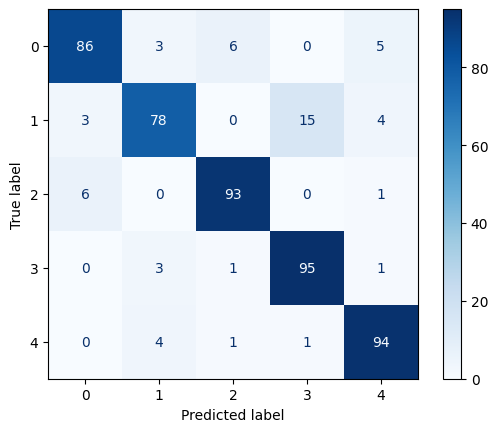

In [42]:
# Asegúrate de tener tus datos de test preparados
Test_images = preparar_imagenes_para_modelo(data_procesada, key_principal='Test')
Test_labels = extraer_etiquetas(data_procesada, key_principal='Test')
metadata_test = extraer_metadata(data_procesada, key_principal='Test')

# Definición de dataloader
test_dataset = torch.utils.data.TensorDataset(Test_images, Test_labels, metadata_test)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False)

true_labels, predicted_labels = predict(model, test_loader, use_gpu=True)
cm = confusion_matrix(true_labels, predicted_labels)

# Visualizar la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1, 2, 3, 4])
disp.plot(cmap=plt.cm.Blues)

report = classification_report(true_labels, predicted_labels, target_names=['AGN', 'SN', 'VS', 'asteroid', 'bogus'])

print(report)

Epoch 1/100
Iteration 117 - Batch 117/2273 - Train loss: 3.700225257465982, Train acc: 0.13087606837606838
Iteration 234 - Batch 234/2273 - Train loss: 3.630207084183, Train acc: 0.17240918803418803
Iteration 351 - Batch 351/2273 - Train loss: 3.603817605564737, Train acc: 0.18892450142450143
Iteration 468 - Batch 468/2273 - Train loss: 3.592459190605033, Train acc: 0.19584668803418803
Iteration 585 - Batch 585/2273 - Train loss: 3.582884201636681, Train acc: 0.20448717948717948
Iteration 702 - Batch 702/2273 - Train loss: 3.5727740763938667, Train acc: 0.21505519943019943
Iteration 819 - Batch 819/2273 - Train loss: 3.5580977147606556, Train acc: 0.23034951159951159
Iteration 936 - Batch 936/2273 - Train loss: 3.544392617085041, Train acc: 0.24315571581196582
Iteration 1053 - Batch 1053/2273 - Train loss: 3.532533741178449, Train acc: 0.25418447293447294
Iteration 1170 - Batch 1170/2273 - Train loss: 3.521983132810674, Train acc: 0.2639423076923077
Iteration 1287 - Batch 1287/2273 - T

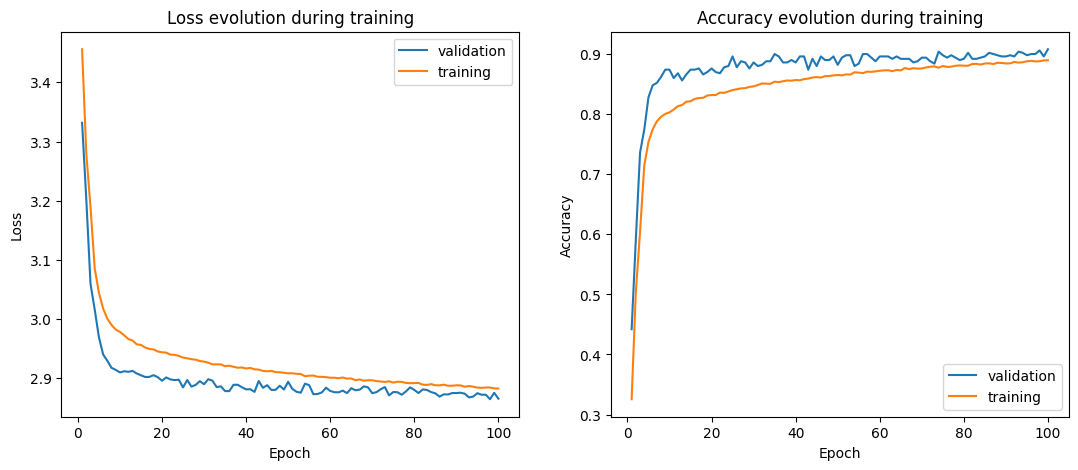

In [43]:
# Instanciación del modelo
lr = 5e-5
dropout_p = 0.6
batch_size = 32
criterion = perdida_regularizada_entropia
epochs = 100
model = CNNModel(dropout_p=dropout_p)

curves = train_model(
    model,
    Train_images,  
    Train_labels,
    metadata_train,
    Val_images,    
    Val_labels,
    metadata_val,
    epochs,
    criterion,
    batch_size,
    lr,
    use_gpu=True,
    beta=0.1,
    patience=30
)



# Mostrar las curvas de entrenamiento
show_curves(curves)



              precision    recall  f1-score   support

         AGN       0.88      0.91      0.90       100
          SN       0.83      0.82      0.82       100
          VS       0.96      0.91      0.93       100
    asteroid       0.86      0.95      0.90       100
       bogus       0.98      0.91      0.94       100

    accuracy                           0.90       500
   macro avg       0.90      0.90      0.90       500
weighted avg       0.90      0.90      0.90       500



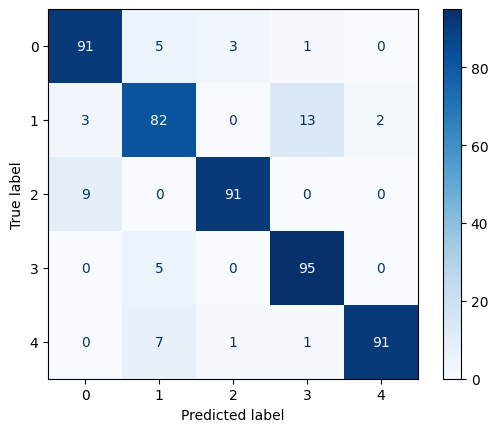

In [44]:
# Asegúrate de tener tus datos de test preparados
Test_images = preparar_imagenes_para_modelo(data_procesada, key_principal='Test')
Test_labels = extraer_etiquetas(data_procesada, key_principal='Test')
metadata_test = extraer_metadata(data_procesada, key_principal='Test')

# Definición de dataloader
test_dataset = torch.utils.data.TensorDataset(Test_images, Test_labels, metadata_test)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

true_labels, predicted_labels = predict(model, test_loader, use_gpu=True)
cm = confusion_matrix(true_labels, predicted_labels)

# Visualizar la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1, 2, 3, 4])
disp.plot(cmap=plt.cm.Blues)

report = classification_report(true_labels, predicted_labels, target_names=['AGN', 'SN', 'VS', 'asteroid', 'bogus'])

print(report)

Epoch 1/100
Iteration 117 - Batch 117/2273 - Train loss: 3.7173804156800623, Train acc: 0.05422008547008547
Iteration 234 - Batch 234/2273 - Train loss: 3.6469257723571906, Train acc: 0.12393162393162394
Iteration 351 - Batch 351/2273 - Train loss: 3.6216087042436302, Train acc: 0.14948361823361822
Iteration 468 - Batch 468/2273 - Train loss: 3.6073600868893485, Train acc: 0.16346153846153846
Iteration 585 - Batch 585/2273 - Train loss: 3.5985176155709815, Train acc: 0.17291666666666666
Iteration 702 - Batch 702/2273 - Train loss: 3.590837864454655, Train acc: 0.18126780626780628
Iteration 819 - Batch 819/2273 - Train loss: 3.584566124192961, Train acc: 0.18757631257631258
Iteration 936 - Batch 936/2273 - Train loss: 3.578264730863082, Train acc: 0.19521233974358973
Iteration 1053 - Batch 1053/2273 - Train loss: 3.572277098979026, Train acc: 0.20278371320037986
Iteration 1170 - Batch 1170/2273 - Train loss: 3.5671333451556344, Train acc: 0.21006944444444445
Iteration 1287 - Batch 1287/

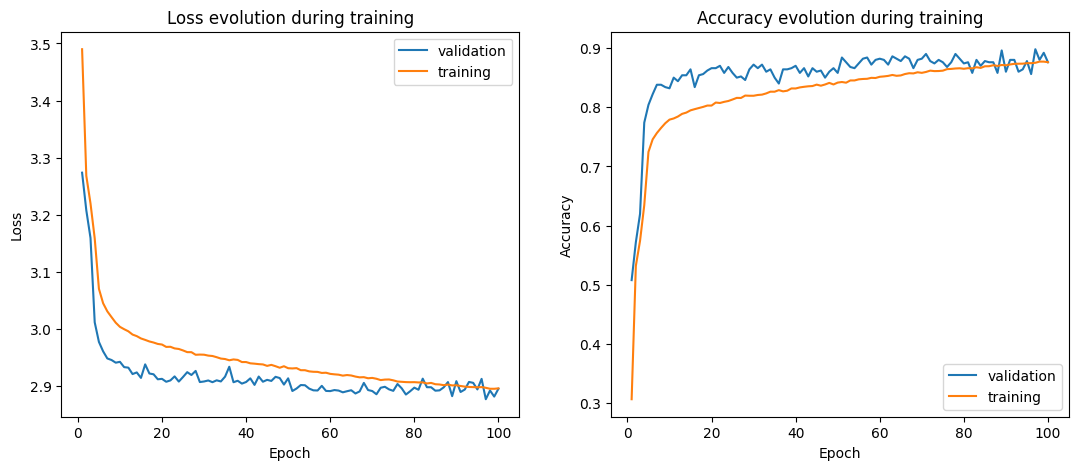

In [45]:
# Instanciación del modelo
lr = 5e-5
dropout_p = 0.7
batch_size = 32
criterion = perdida_regularizada_entropia
epochs = 100
model = CNNModel(dropout_p=dropout_p)

curves = train_model(
    model,
    Train_images,  
    Train_labels,
    metadata_train,
    Val_images,    
    Val_labels,
    metadata_val,
    epochs,
    criterion,
    batch_size,
    lr,
    use_gpu=True,
    beta=0.1,
    patience=20
)



# Mostrar las curvas de entrenamiento
show_curves(curves)



              precision    recall  f1-score   support

         AGN       0.91      0.91      0.91       100
          SN       0.90      0.72      0.80       100
          VS       0.89      0.93      0.91       100
    asteroid       0.86      0.95      0.90       100
       bogus       0.90      0.95      0.93       100

    accuracy                           0.89       500
   macro avg       0.89      0.89      0.89       500
weighted avg       0.89      0.89      0.89       500



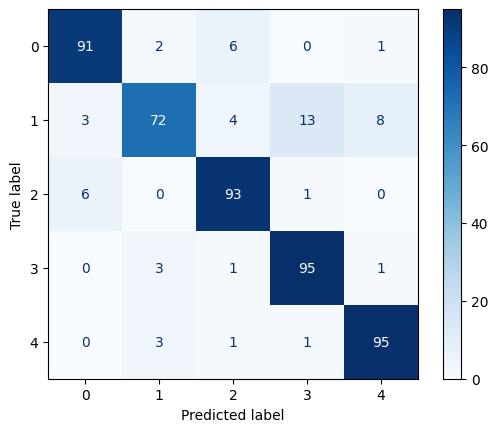

In [46]:
# Asegúrate de tener tus datos de test preparados
Test_images = preparar_imagenes_para_modelo(data_procesada, key_principal='Test')
Test_labels = extraer_etiquetas(data_procesada, key_principal='Test')
metadata_test = extraer_metadata(data_procesada, key_principal='Test')

# Definición de dataloader
test_dataset = torch.utils.data.TensorDataset(Test_images, Test_labels, metadata_test)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

true_labels, predicted_labels = predict(model, test_loader, use_gpu=True)
cm = confusion_matrix(true_labels, predicted_labels)

# Visualizar la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1, 2, 3, 4])
disp.plot(cmap=plt.cm.Blues)

report = classification_report(true_labels, predicted_labels, target_names=['AGN', 'SN', 'VS', 'asteroid', 'bogus'])

print(report)

Epoch 1/100
Iteration 117 - Batch 117/2273 - Train loss: 2.0789039318378153, Train acc: 0.02216880341880342
Iteration 234 - Batch 234/2273 - Train loss: 2.078725120960138, Train acc: 0.026709401709401708
Iteration 351 - Batch 351/2273 - Train loss: 2.0785311674460387, Train acc: 0.03178418803418803
Iteration 468 - Batch 468/2273 - Train loss: 2.0776742024299426, Train acc: 0.04720886752136752
Iteration 585 - Batch 585/2273 - Train loss: 2.0659328941606048, Train acc: 0.07425213675213675
Iteration 702 - Batch 702/2273 - Train loss: 2.0419857060467757, Train acc: 0.09602029914529915
Iteration 819 - Batch 819/2273 - Train loss: 2.0240663442856226, Train acc: 0.11046245421245421
Iteration 936 - Batch 936/2273 - Train loss: 2.0099913006664343, Train acc: 0.1219951923076923
Iteration 1053 - Batch 1053/2273 - Train loss: 2.0000503866987236, Train acc: 0.12995607787274455
Iteration 1170 - Batch 1170/2273 - Train loss: 1.9916433371030366, Train acc: 0.13640491452991452
Iteration 1287 - Batch 12

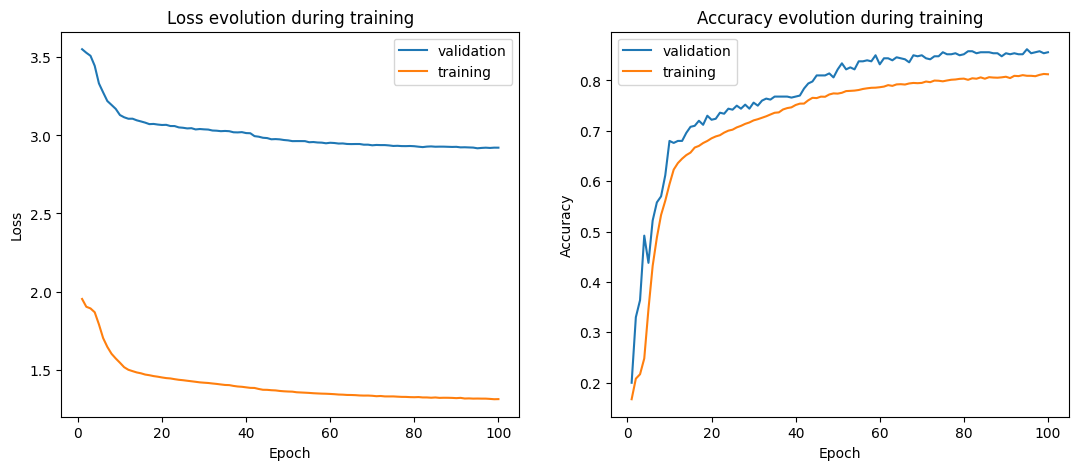

In [47]:
# Instanciación del modelo
lr = 5e-6
dropout_p = 0.6
batch_size = 32
criterion = perdida_regularizada_entropia
epochs = 100
model = CNNModel(dropout_p=dropout_p)

curves = train_model(
    model,
    Train_images,  
    Train_labels,
    metadata_train,
    Val_images,    
    Val_labels,
    metadata_val,
    epochs,
    criterion,
    batch_size,
    lr,
    use_gpu=True,
    beta=0.5,
    patience=20
)



# Mostrar las curvas de entrenamiento
show_curves(curves)



              precision    recall  f1-score   support

         AGN       0.89      0.85      0.87       100
          SN       0.85      0.71      0.77       100
          VS       0.91      0.89      0.90       100
    asteroid       0.84      0.96      0.90       100
       bogus       0.83      0.90      0.87       100

    accuracy                           0.86       500
   macro avg       0.86      0.86      0.86       500
weighted avg       0.86      0.86      0.86       500



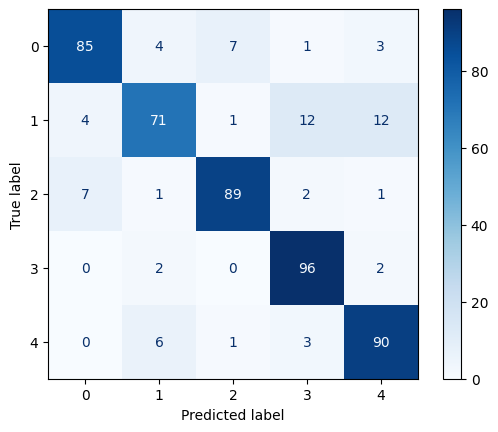

In [48]:
# Asegúrate de tener tus datos de test preparados
Test_images = preparar_imagenes_para_modelo(data_procesada, key_principal='Test')
Test_labels = extraer_etiquetas(data_procesada, key_principal='Test')
metadata_test = extraer_metadata(data_procesada, key_principal='Test')

# Definición de dataloader
test_dataset = torch.utils.data.TensorDataset(Test_images, Test_labels, metadata_test)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

true_labels, predicted_labels = predict(model, test_loader, use_gpu=True)
cm = confusion_matrix(true_labels, predicted_labels)

# Visualizar la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1, 2, 3, 4])
disp.plot(cmap=plt.cm.Blues)

report = classification_report(true_labels, predicted_labels, target_names=['AGN', 'SN', 'VS', 'asteroid', 'bogus'])

print(report)

In [49]:
# Instanciación del modelo
lr = 5e-5
dropout_p = 0.6
batch_size = 32
criterion = perdida_regularizada_entropia
epochs = 100
model = CNNModel(dropout_p=dropout_p)

curves = train_model(
    model,
    Train_images,  
    Train_labels,
    Val_images,    
    Val_labels,
    epochs,
    criterion,
    batch_size,
    lr,
    use_gpu=True,
    beta=0.4, 
    patience=30
)


# Mostrar las curvas de entrenamiento
show_curves(curves)



TypeError: train_model() missing 2 required positional arguments: 'batch_size' and 'lr'

In [ ]:
# Asegúrate de tener tus datos de test preparados
Test_images = preparar_imagenes_para_modelo(data_procesada, key_principal='Test')
Test_labels = extraer_etiquetas(data_procesada, key_principal='Test')
metadata_test = extraer_metadata(data_procesada, key_principal='Test')

# Definición de dataloader
test_dataset = torch.utils.data.TensorDataset(Test_images, Test_labels, metadata_test)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

true_labels, predicted_labels = predict(model, test_loader, use_gpu=True)
cm = confusion_matrix(true_labels, predicted_labels)

# Visualizar la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1, 2, 3, 4])
disp.plot(cmap=plt.cm.Blues)

report = classification_report(true_labels, predicted_labels, target_names=['AGN', 'SN', 'VS', 'asteroid', 'bogus'])

print(report)

# RandomSearch

In [104]:
import random

# 1. Define los rangos de los hiperparámetros
param_grid = {
    'dropout_p': [0.3, 0.4, 0.5, 0.6, 0.7, 0.8],
    'batch_size': [32, 64],
    'lr': [1e-4, 1e-3, 1e-2, 1e-5],
    'beta': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
}

# 2. Número de combinaciones a probar
num_combinations = 40

# 3. Realiza la búsqueda aleatoria
best_val_acc = 0
best_params = None
results = []

for i in range(num_combinations):
    print(f"Combinación {i + 1}/{num_combinations}")
    
    # Genera una combinación aleatoria de hiperparámetros
    params = {k: random.choice(v) for k, v in param_grid.items()}
    
    # Inicializa el modelo
    model = CNNModel(params['dropout_p'])
    
    # Entrena el modelo y evalúalo
    curves = train_model(
        model,
        Train_images,
        Train_labels,
        metadata_train,
        Val_images,
        Val_labels,
        metadata_val,
        epochs=100,  # Puedes ajustar este número según tus necesidades
        criterion=perdida_regularizada_entropia,
        batch_size=params['batch_size'],
        lr=params['lr'],
        use_gpu=True,
        beta=params['beta'],
        patience=20
    )
    

    val_acc = max(curves['val_acc'])
    
    # Guarda los resultados
    results.append({
        'params': params,
        'val_acc': val_acc,
        'curves': curves,
    })
    
    # Actualiza los mejores parámetros si es necesario
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_params = params

print("Búsqueda completada")
print(f"Mejor precisión de validación: {best_val_acc}")
print(f"Mejores parámetros: {best_params}")


Combinación 1/40
Epoch 1/100
Iteration 117 - Batch 117/2273 - Train loss: 1.2476501398616366, Train acc: 0.4594017094017094
Iteration 234 - Batch 234/2273 - Train loss: 1.043377119761247, Train acc: 0.562232905982906
Iteration 351 - Batch 351/2273 - Train loss: 0.9144959413258099, Train acc: 0.6209935897435898
Iteration 468 - Batch 468/2273 - Train loss: 0.8297873257826536, Train acc: 0.6592548076923077
Iteration 585 - Batch 585/2273 - Train loss: 0.7702553390437721, Train acc: 0.6844017094017094
Iteration 702 - Batch 702/2273 - Train loss: 0.7225713980758292, Train acc: 0.7060630341880342
Iteration 819 - Batch 819/2273 - Train loss: 0.6841691821740806, Train acc: 0.7230235042735043
Iteration 936 - Batch 936/2273 - Train loss: 0.6515019441134909, Train acc: 0.7365785256410257
Iteration 1053 - Batch 1053/2273 - Train loss: 0.6252193663902545, Train acc: 0.7469432573599241
Iteration 1170 - Batch 1170/2273 - Train loss: 0.6019160595459816, Train acc: 0.7571314102564103
Iteration 1287 - Ba